Heart Failures - ML in healthcare
===

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import norm
# from sklearn.preprocessing import StandardScaler
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline
import torch
import torch.nn.functional as F
# import param

In [5]:
# import sklearn as sk
# import scipy

In [8]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [9]:
# import py_lib as lib
import graph as gr
import params as par
reload(gr)
reload(par)
import graph as gr
import params as par

In [10]:
format_dict = par.create_format_dict()
format_dict

{'Age': '{:.0f}',
 'RestingBP': '{:.0f}',
 'Cholesterol': '{:.0f}',
 'MaxHR': '{:.0f}',
 'FastingBS': '{:.1f}',
 'HeartDisease': '{:.1f}',
 'Oldpeak': '{:.2f}'}

# Import Data

In [11]:
df_heart = pd.read_csv('heart.csv')
# df_heart_test = pd.read_csv('ml4h_data/project1/heart_failure/test_split.csv')
# df_heart_train = pd.read_csv('ml4h_data/project1/heart_failure/train_val_split.csv')
df_heart_test = pd.read_csv('test_split.csv')
df_heart_train = pd.read_csv('train_val_split.csv')

In [12]:
df_heart.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1


In [13]:
df_heart.describe().style.format(format_dict)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918,918,918,918.0,918,918.00,918.0
mean,54,132,199,0.2,137,0.89,0.6
std,9,19,109,0.4,25,1.07,0.5
min,28,0,0,0.0,60,-2.60,0.0
25%,47,120,173,0.0,120,0.00,0.0
50%,54,130,223,0.0,138,0.60,1.0
75%,60,140,267,0.0,156,1.50,1.0
max,77,200,603,1.0,202,6.20,1.0


In [14]:
df_heart_test.describe().style.format(format_dict)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,184,184,184,184.0,184,184.00,184.0
mean,53,134,204,0.2,139,0.94,0.6
std,10,18,111,0.4,26,1.00,0.5
min,28,92,0,0.0,71,-2.60,0.0
25%,48,120,177,0.0,120,0.00,0.0
50%,54,130,223,0.0,140,1.00,1.0
75%,60,145,265,0.0,160,1.60,1.0
max,75,200,603,1.0,202,4.00,1.0


In [15]:
df_heart_train.describe().style.format(format_dict)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,734,734,734,734.0,734,734.00,734.0
mean,54,132,198,0.2,136,0.87,0.5
std,9,19,109,0.4,25,1.08,0.5
min,29,0,0,0.0,60,-2.00,0.0
25%,47,120,172,0.0,120,0.00,0.0
50%,54,130,222,0.0,138,0.50,1.0
75%,60,140,267,0.0,155,1.50,1.0
max,77,200,529,1.0,195,6.20,1.0


## Variables by data types

In [16]:
df_heart.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [17]:
dft = df_heart.dtypes
cols_num = list(dft[dft == 'int64'].index)
cols_num.append('Oldpeak')
cols_num_with_binary = [x for x in cols_num]
cols_num.remove('FastingBS')
cols_num.remove('HeartDisease')
cols_num

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [18]:
cols_obj = list(dft[dft == 'object'].index)
cols_obj_pure = [x for x in cols_obj]
cols_obj.append('FastingBS')
cols_obj.append('HeartDisease')
cols_obj

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'FastingBS',
 'HeartDisease']

In [19]:
col_names = list(df_heart.columns)
col_names

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

## Numerical variables distributions

In [20]:
cols_num

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [21]:
df_heart['FastingBS'].value_counts().values

array([704, 214])

In [22]:
import graph as gr
reload(gr)
import graph as gr

/home/pinolej/eth/healthcare/heart/graph.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


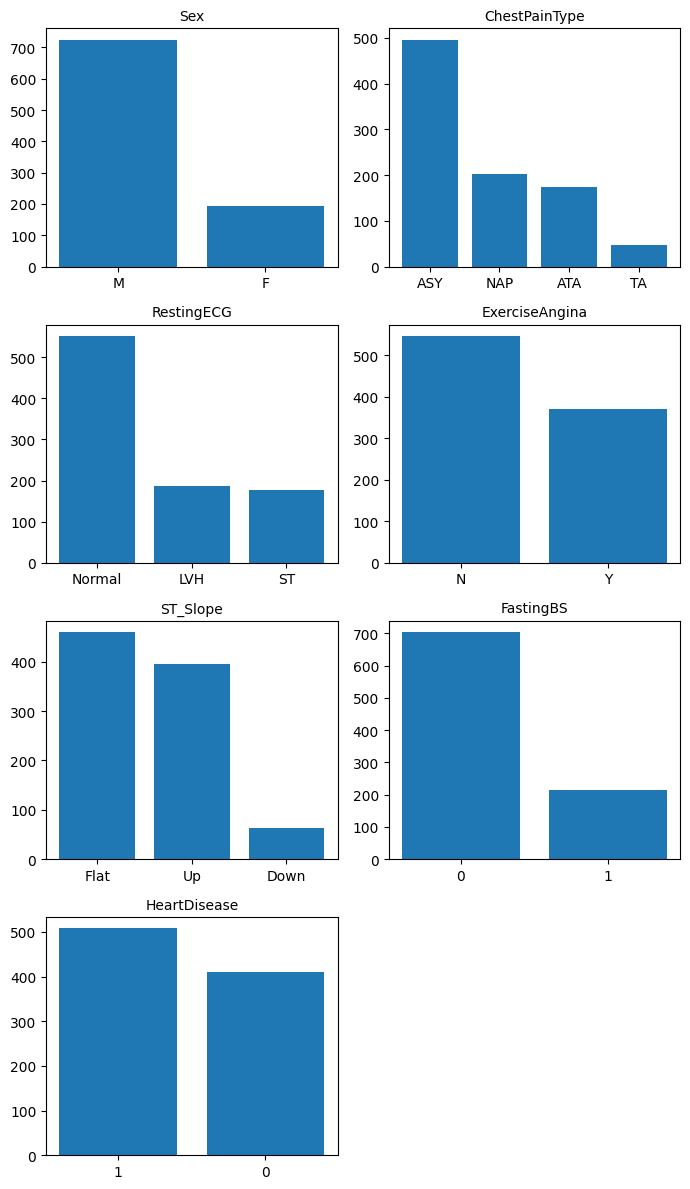

In [23]:
gr.dist_mult_plots(
    df_heart,
    cols=cols_obj,
    figsize=(7, 12),
    ncols=2,
    bar_plot=True,
    fontsize={
        'ax_title': 10,
    },
    custom_bins={'FastingBS': 60},
)

/home/pinolej/eth/healthcare/heart/graph.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


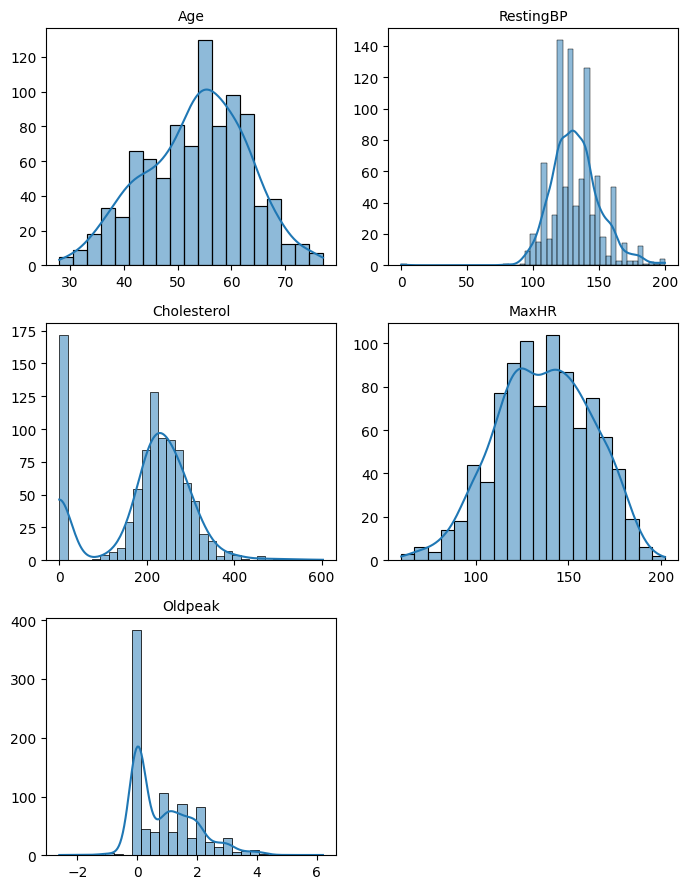

In [24]:
gr.dist_mult_plots(
    df_heart,
    cols=cols_num,
    figsize=(7, 9),
    ncols=2,
    fontsize={
        'ax_title': 10,
    },
    custom_bins={'FastingBS': 60},
)

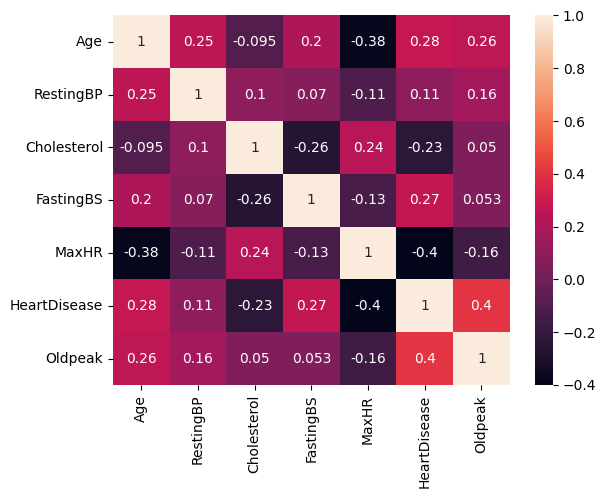

In [25]:
sns.heatmap(df_heart[cols_num_with_binary].corr(), annot=True)
plt.show()

## Missing values and Outliers

In [26]:
df_heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

# Lasso Logistic Regression

## Features Preprocessing

In [27]:
cols_obj_pure

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [28]:
label_col = 'HeartDisease'
cols_num_with_binary
features = [x for x in cols_num_with_binary]
features.remove(label_col)
features

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

In [29]:
X_train, X_test = torch.Tensor(df_heart_train[features].to_numpy()),torch.Tensor(df_heart_test[features].to_numpy())
y_train, y_test = torch.Tensor(df_heart_train[label_col].to_numpy()),torch.Tensor(df_heart_test[label_col].to_numpy())

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
x_norm = {}
scaler = MinMaxScaler() 
x_norm['train'] = scaler.fit_transform(df_heart_train[features])
x_norm['test'] = scaler.transform(df_heart_test[features])
# for key, df in {'train': df_heart_train[features], 'test': df_heart_test[features]}.items():
#     min_max_scaler = MinMaxScaler().fit(df)
#     x_norm[key] = min_max_scaler.transform(df)

In [33]:
x_norm_init = {x: df for x, df in x_norm.items()}

In [34]:
key = 'train'
x_norm[key]-x_norm_init[key]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

## Model Building

In [35]:
class LogisticParams(param.Parameterized):
    lr                       = param.Number(0.02,bounds=(10**(-8), 0.3),doc="Learning Rate")
    epochs                   = param.Integer(default=5 ,bounds=(1,10000))
    num_var                  = param.ObjectSelector(default="Age",objects=cols_num)
#     boolean                 = param.Boolean(True, doc="A sample Boolean parameter")
# pn.Param(CustomExample.param, widgets={
#     'select_string': {'type': pn.widgets.RadioButtonGroup, 'button_type': 'primary'},
#     'select_number': pn.widgets.DiscretePlayer}
# )

In [36]:
base = LogisticParams()
pn.Row(base.param)
# pn.Row(Example.param, base.param)

BokehModel(combine_events=True, render_bundle={'docs_json': {'1a305820-21b8-411e-82a3-7e8d30c066c9': {'version…

In [37]:
print('hello')

hello


In [38]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

In [39]:
input_dim = len(features) # Two inputs x1 and x2 
output_dim = 1 # Single binary output
model = LogisticRegression(input_dim,output_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LogisticParams.lr)

In [40]:
features + [label_col]

['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'HeartDisease']

In [41]:
df_heart_train[features+cols_obj_pure].head(2)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,40,140,289,0,172,0.0,M,ATA,Normal,N,Up
1,37,130,283,0,98,0.0,M,ATA,ST,N,Up


In [42]:
df_heart_train[features].head(2)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
0,40,140,289,0,172,0.0
1,37,130,283,0,98,0.0


## Training

In [43]:
# from sklearn.model_selection import train_test_split
torch.manual_seed(0) # keep things reproducible

In [44]:
LogisticParams.lr = 7*10**-3
optimizer = torch.optim.SGD(model.parameters(), lr=LogisticParams.lr)

In [45]:
LogisticParams.epochs = 5000
iter_array = 5
iter_printing = int(LogisticParams.epochs/5)

In [46]:
X_train, X_test = torch.Tensor(x_norm['train']),torch.Tensor(x_norm['test'])
y_train, y_test = torch.Tensor(df_heart_train[label_col].to_numpy()),torch.Tensor(df_heart_test[label_col].to_numpy())

In [ ]:
# X_train, X_test = torch.Tensor(df_heart_train[features].to_numpy()),torch.Tensor(df_heart_test[features].to_numpy())
# y_train, y_test = torch.Tensor(df_heart_train[label_col].to_numpy()),torch.Tensor(df_heart_test[label_col].to_numpy())

In [47]:
losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(LogisticParams.epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%iter_array==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_test))
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)

            if iter%iter_printing==0:
                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:  32%|███▏      | 1581/5000 [00:00<00:01, 2911.89it/s]

Iteration: 1000. 
Test - Loss: 0.644527792930603. Accuracy: 65.21739130434783
Train -  Loss: 0.6546505093574524. Accuracy: 60.35422343324251



Training Epochs:  50%|█████     | 2513/5000 [00:00<00:00, 3051.25it/s]

Iteration: 2000. 
Test - Loss: 0.6176072955131531. Accuracy: 76.08695652173913
Train -  Loss: 0.6258620023727417. Accuracy: 73.70572207084469



Training Epochs:  68%|██████▊   | 3409/5000 [00:01<00:00, 2787.04it/s]

Iteration: 3000. 
Test - Loss: 0.5997506976127625. Accuracy: 76.08695652173913
Train -  Loss: 0.605631947517395. Accuracy: 75.34059945504087



Training Epochs:  90%|████████▉ | 4487/5000 [00:01<00:00, 2553.51it/s]

Iteration: 4000. 
Test - Loss: 0.5871571898460388. Accuracy: 76.6304347826087
Train -  Loss: 0.5905454754829407. Accuracy: 75.88555858310627



Training Epochs: 100%|██████████| 5000/5000 [00:01<00:00, 2707.53it/s]

Iteration: 5000. 
Test - Loss: 0.5778496265411377. Accuracy: 73.91304347826087
Train -  Loss: 0.5787454843521118. Accuracy: 75.20435967302453



/tmp/ipykernel_13965/3125753765.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


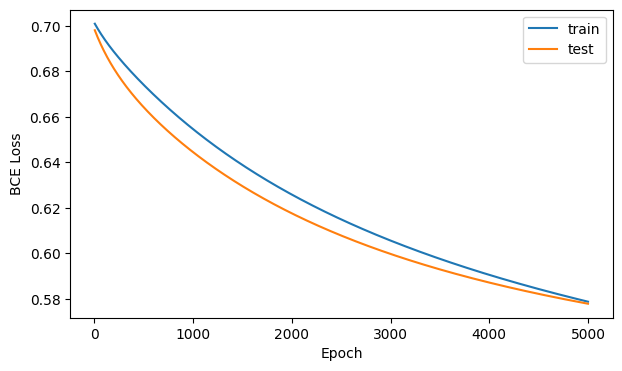

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,4))
ax.plot(Iterations,losses, label='train')
ax.plot(Iterations,losses_test, label='test')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('BCE Loss')
fig.show()

In [50]:
from torchmetrics.classification import BinaryF1Score

In [51]:
dim_1 = 0
dim_2 = 1

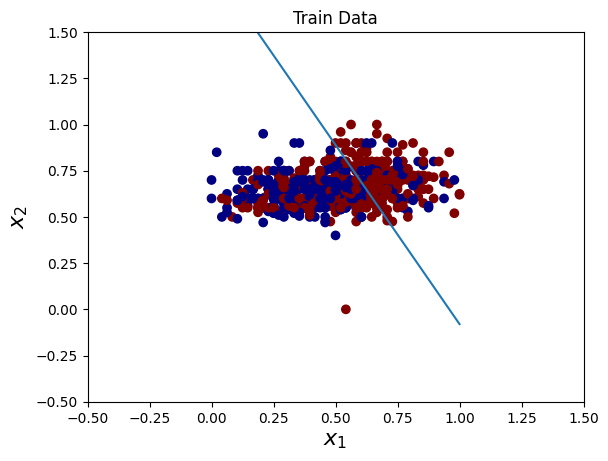

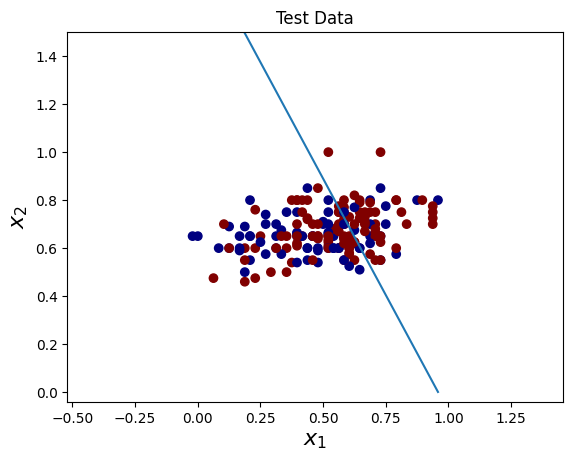

In [52]:
def model_plot(model,X,y,title,dim_1,dim_2):
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().numpy()  
    
    w = parm['linear.weight'][0]
    b = parm['linear.bias'][0]
    plt.scatter(X[:, dim_1], X[:, dim_2], c=y,cmap='jet')
    u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    plt.plot(u, (0.5-b-w[0]*u)/w[1])
    plt.xlim(X[:, dim_1].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, dim_2].min()-0.5, X[:, 1].max()+0.5)
    plt.xlabel(r'$\boldsymbol{x_1}$',fontsize=16) # Normally you can just add the argument fontweight='bold' but it does not work with latex
    plt.ylabel(r'$\boldsymbol{x_2}$',fontsize=16)
    plt.title(title)
    plt.show()


# Train Data
model_plot(model,X_train,y_train,'Train Data',dim_1,dim_2)

# Test Dataset Results
model_plot(model,X_test,y_test,'Test Data',dim_1,dim_2)

In [43]:
model_2 = torch.nn.Sequential(
    torch.nn.Linear(3, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 1),
)

print(model_2(torch.randn(4, 3))) # feed it 4 random 3-dim. vectors

tensor([[0.3709],
        [0.4930],
        [0.4063],
        [0.3934]], grad_fn=<AddmmBackward0>)


### Adding One-hot Encoding

In [ ]:
A = torch.tensor([3, 4, 5, 0, 1, 2])
output = F.one_hot(A, num_classes = 7)
print(output)
scalar_dim = 3
num_classes = 10

Fun.one_hot(torch.LongTensor([scalar_dim]), num_classes=num_classes)

In [ ]:
num_classes = len(df_heart_train[[cols_obj_pure[0]]].value_counts()) + 1

In [ ]:
Fun.one_hot(torch.Tensor(df_heart_train[cols_obj_pure[0]].to_numpy()), num_classes = num_classes)

In [ ]:
X_train, X_test = torch.Tensor(df_heart_train[features + cols_obj_pure].to_numpy()),torch.Tensor(df_heart_test[features + cols_obj_pure].to_numpy())
y_train, y_test = torch.Tensor(df_heart_train[label_col].to_numpy()),torch.Tensor(df_heart_test[label_col].to_numpy())

# Appendix

In [ ]:
# class Example(BaseClass):
#     """An example Parameterized class"""
#     timestamps = []

#     boolean                 = param.Boolean(True, doc="A sample Boolean parameter")
#     color                   = param.Color(default='#FFFFFF')
#     date                    = param.Date(dt.datetime(2017, 1, 1),
#                                          bounds=(dt.datetime(2017, 1, 1), dt.datetime(2017, 2, 1)))
#     select_string           = param.ObjectSelector(default="yellow",objects=["red","yellow","green"])
#     select_fn               = param.ObjectSelector(default=list,objects=[list,set,dict])
#     int_list                = param.ListSelector(default=[3,5], objects=[1,3,5,7,9],precedence=0.5)
#     single_file             = param.FileSelector(path='../../*/*.py*',precedence=0.5)
#     multiple_files          = param.MultiFileSelector(path='../../*/*.py?',precedence=0.5)
#     record_timestamp        = param.Action(lambda x: x.timestamps.append(dt.datetime.now()),
#                                            doc="""Record timestamp.""",precedence=0.7)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
 df_heart_train[features + cols_obj_pure], df_heart_train[label_col], test_size=0.33, random_state=42)